# <font color='red'>IMPORTANT
This jupyter notebook served as a development platform and was used in google colab. As such all of the code is created with this in mind. The main logic of the ALPR pipeline is condensed in **FlaskWebApp/app/ALPR.py**. The results for the ALPR part in the Evaluation part of the thesis are taken from this notebook.</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Import libraries

In [ ]:
!sudo apt install -q tesseract-ocr
!pip install -q pytesseract
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

# !pip install -q easyocr
# import easyocr

from imutils.perspective import order_points
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
from imutils import contours
from typing import Union
from scipy import stats
import pandas as pd
import numpy as np
import imutils
import time
import cv2
import os
import re

Reading package lists...
Building dependency tree...
Reading state information...
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
  Using cached Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.1.0
    Uninstalling Pillow-9.1.0:
      Successfully uninstalled Pillow-9.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires pillow!=8.3.0,>=5.3.0, but you have pillow 4.1.1 which is incompatible.
scikit-image 0.18

# Helper functions

In [ ]:
def dbg(debug:bool, text:str, image:np.ndarray) -> None:
  if not debug:
    return
  if type(image) == cv2.UMat:
    image = cv2.UMat.get(image)
  if text is not None: 
    print(text)
  if image is not None:
    cv2_imshow(image)

In [ ]:
def dirty_ratio_check(width:int, height:int) -> bool:
  if width == 0 or height == 0:
    return False

  ratio = float(width / height)
  if ratio < 1:
    return False

  if 2.3 < ratio < 8.5: # rectangle ratio
    return True
  elif 1 < ratio < 2.1: # square ratio
    return True
  
  return False

In [ ]:
def clean_ratio_check(image_shape:tuple, width:int, height:int) -> bool:
  ratio = float(width / height)
  if ratio < 1:
    ratio = 1 / ratio

  if 3 < ratio <= 6.4 and width < 0.7 * image_shape[0]: # rectangle ratio - <6 ORIGINALLY
    return True
  elif 1 < ratio < 1.8: # square ratio
    return True

  return False

In [ ]:
def perspective_transformation(image:np.ndarray, contour:np.ndarray) -> np.ndarray:
  hull = cv2.convexHull(contour, returnPoints=True)
  box = cv2.minAreaRect(hull)
  box = cv2.boxPoints(box)
  box = np.array(box, dtype="int")
  src_pts = order_points(box)

  # correct contour coords as they are tied to original image, not contour cutout
  width_offset = min(src_pts[:,0])
  height_offset = min(src_pts[:,1])
  src_pts_corrected = np.array([[x - width_offset, y - height_offset] for x, y in src_pts])

  # use Euclidean distance to get width & height
  width = int(np.linalg.norm(src_pts[0] - src_pts[1]))
  height = int(np.linalg.norm(src_pts[0] - src_pts[3]))
  dst_pts = np.array([[0,0], [width,0], [width,height], [0,height]], dtype=np.float32)

  M = cv2.getPerspectiveTransform(src_pts_corrected, dst_pts)
  warped = cv2.warpPerspective(image, M, (width, height))

  return warped

In [ ]:
def get_contours(original_image:np.ndarray, debug:bool=False) -> list:  
  """
    Execute grayscale transform, gaussian blurring, sobel X edge
    detection & correction, adaptive thresholding and close image.

    Returns: grayscale image and closed image.
  """
  image = cv2.UMat(original_image)
  dbg(debug, "Original image", image)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  dbg(debug, "Gray", gray)

  blurred = cv2.GaussianBlur(gray, (7,7), 0)
  dbg(debug, "Blurred", blurred)

  sobelx = cv2.Sobel(blurred, cv2.CV_32F, 1, 0, ksize=-1)
  dbg(debug, "Sobel X", sobelx)

  # do not miss edges with negative slopes (white-to-black)
  sobelx = cv2.UMat.get(sobelx)
  sobelx = np.absolute(sobelx)
  minVal, maxVal = np.min(sobelx), np.max(sobelx)
  sobelx = 255 * ((sobelx - minVal) / (maxVal - minVal))
  sobelx = sobelx.astype(np.uint8)
  sobelx = cv2.UMat(sobelx)
  dbg(debug, "Sobel X corrected", sobelx)

  thresh = cv2.adaptiveThreshold(sobelx, 255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv2.THRESH_BINARY_INV, blockSize=15, C=10)
  dbg(debug, "Threshold", thresh)

  close = cv2.morphologyEx(thresh, op=cv2.MORPH_CLOSE, kernel=np.ones((3,20), np.uint8))
  dbg(debug, "Close 3x20", close)

  # calculate maximum plate area
  plate_area = original_image.shape[0] * original_image.shape[1] * 0.15

  # --------------- get 7 biggest contours for classic pipeline ---------------
  final_1 = cv2.morphologyEx(close, op=cv2.MORPH_OPEN, kernel=np.ones((3,20), np.uint8))
  dbg(debug, "Final Edge-focused", final_1)

  contours_1 = cv2.findContours(final_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  contours_1 = sorted(contours_1, key=cv2.contourArea, reverse=True)[:7]
  contours_1 = [x for x in contours_1 if cv2.contourArea(x) < plate_area]

  # --------------- get 7 biggest contours for light mask pipeline ---------------
  light = cv2.morphologyEx(gray, op=cv2.MORPH_CLOSE, kernel=np.ones((5,5), np.uint8))
  dbg(debug, "Light mask 1", light)

  light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  dbg(debug, "Light mask 2", light)

  bit_and = cv2.bitwise_and(close, close, mask=light)
  dbg(debug, "Bit AND", bit_and)

  dilate = cv2.dilate(bit_and, kernel=np.ones((3,3), np.uint8), iterations=2)
  dbg(debug, "Dilate 3x3", dilate)

  close = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel=np.ones((3,3), np.uint8))
  dbg(debug, "Close 3x3", close)

  final_2 = cv2.morphologyEx(close, op=cv2.MORPH_OPEN, kernel=np.ones((3,20), np.uint8))
  dbg(debug, "Final Light mask", final_2)

  contours_2 = cv2.findContours(final_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  contours_2 = sorted(contours_2, key=cv2.contourArea, reverse=True)[:7]
  contours_2 = [x for x in contours_2 if cv2.contourArea(x) < plate_area]

  return sorted(contours_1 + contours_2, key=cv2.contourArea, reverse=True)[:8]

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def clean2_plate(original_image_shape:tuple, original_plate:np.ndarray, debug:bool=False) -> Union[np.ndarray, bool]:
  plate = cv2.UMat(original_plate)

  gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
  dbg(debug, "Gray", gray)

  equalized = clahe.apply(gray)
  # equalized = cv2.equalizeHist(gray)
  dbg(debug, "Equalized", equalized)

  blurred = cv2.bilateralFilter(equalized, 11, 75, 75)
  dbg(debug, "Blurred", blurred)

  #------------------------------ Adaptive Binary ------------------------------
  thresh_binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7)
  dbg(debug, "Threshold adaptive binary", thresh_binary)

  contours_1 = cv2.findContours(thresh_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  contours_1 = sorted(contours_1, key=cv2.contourArea, reverse=True)[:5]
  #------------------------------ Adaptive Inverse -----------------------------
  thresh_inverse = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 5)
  dbg(debug, "Threshold adaptive inverse", thresh_inverse)

  dilate = cv2.dilate(thresh_inverse, kernel=np.ones((2,2), np.uint8))
  dbg(debug, "Dilate", dilate)

  contours_2 = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  contours_2 = sorted(contours_2, key=cv2.contourArea, reverse=True)[:5]
  #----------------------------------- OTSU ------------------------------------
  thresh_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  dbg(debug, "Threshold OTSU", thresh_otsu)

  close = cv2.morphologyEx(thresh_otsu, op=cv2.MORPH_CLOSE, kernel=np.ones((5,13), np.uint8))
  dbg(debug, "Close", close)

  open = cv2.morphologyEx(close, op=cv2.MORPH_OPEN, kernel=np.ones((1,20), np.uint8))
  dbg(debug, "Open", open)

  contours_3 = cv2.findContours(open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  contours_3 = sorted(contours_3, key=cv2.contourArea, reverse=True)[:5]
  #-----------------------------------------------------------------------------
  plate_area = original_plate.shape[0] * original_plate.shape[1]
  contours = contours_1 + contours_2 + contours_3
  contours = [x for x in contours if plate_area * 0.4 < cv2.contourArea(x) < plate_area * 0.95]
  contours = sorted(contours, key=cv2.contourArea)
  if debug: print("Number of contours:", len(contours))

  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    final_img = original_plate[y:y+h, x:x+w]
    dbg(debug, "from clean_plate", final_img)

    if clean_ratio_check(original_image_shape, w, h, debug):
      return final_img, True
  
  if debug: print("Plate cleaning failed!")
  return original_plate, False

## Character segmentation

In [ ]:
def is_text_valid(char_text:str) -> bool:
  letter_flag = number_flag = False
  for i in char_text:
    if i.isdigit():
      number_flag = True
    elif i.isalpha():
      letter_flag = True

  return letter_flag and number_flag

In [ ]:
# not used # not used # not used # not used # not used # not used # not used # not used # not used # not used # not used # not used 
def perspective_transformation_characters(image:np.ndarray, leftmost_contour:np.ndarray, rightmost_contour:np.ndarray, debug:bool=False) -> np.ndarray:
  hull = cv2.convexHull(leftmost_contour, returnPoints=True)
  box = cv2.minAreaRect(hull)
  box = cv2.boxPoints(box)
  box = np.array(box, dtype="int")
  left_src_pts = order_points(box)
  if debug: print(left_src_pts)

  hull = cv2.convexHull(rightmost_contour, returnPoints=True)
  box = cv2.minAreaRect(hull)
  box = cv2.boxPoints(box)
  box = np.array(box, dtype="int")
  right_src_pts = order_points(box)
  if debug: print(right_src_pts)

  src_pts = np.array([left_src_pts[0], right_src_pts[1], right_src_pts[2], left_src_pts[3]]) - 10
  if debug: print(src_pts)

  # use Euclidean distance to get width & height
  width = int(np.linalg.norm(src_pts[0] - src_pts[1]))
  height = int(np.linalg.norm(src_pts[0] - src_pts[3]))
  if debug: print(f"Width: {width}  Height: {height}")

  dst_pts = np.array([[0,0], [width,0], [width,height], [0,height]], dtype=np.float32)
  if debug: print(dst_pts)

  M = cv2.getPerspectiveTransform(src_pts, dst_pts)
  warped = cv2.warpPerspective(image, M, (width + 20, height + 20))
  dbg(debug, "Warped", warped)

  return warped

In [ ]:
def postprocess_text(char_text:str) -> str:
  char_list = list(char_text)

  '''This would be used if we could make sure that the license plate follow such a pattern.'''
  # text_length = len(char_list)
  # half_len = int(text_length / 2)
  # num_to_letter = {'1':'I', '4':'A', '5':'S', '7':'Z', '8':'B'}
  
  # for key in num_to_letter.keys():
  #   if key in char_list[0:2]:
  #     char_list[0:2] = char_text[0:2].replace(key, num_to_letter[key])
  #   if text_length % 2 == 0:
  #     if num_to_letter[key] in char_list[half_len - 1:half_len + 1]:
  #       print(char_text[half_len - 1:half_len + 1])
  #       char_list[half_len - 1:half_len + 1] = char_text[half_len - 1:half_len + 1].replace(num_to_letter[key], key)
  #   else:
  #     if num_to_letter[key] in char_list[half_len - 1:half_len + 2]:
  #       print(num_to_letter[key], char_text[half_len - 1:half_len + 2])
  #       char_list[half_len-1:half_len + 2] = char_text[half_len-1:half_len + 2].replace(num_to_letter[key], key)
  if '7' in char_list[0:2]:
    char_list[0:2] = char_text[0:2].replace('7', 'Z')

  return ''.join(char_list)

In [ ]:
def pytesseract_image_to_string(image:np.ndarray, oem:int=3, psm:int=7) -> str:
  '''
  oem - OCR Engine Mode
      0 = Original Tesseract only.
      1 = Neural nets LSTM only.
      2 = Tesseract + LSTM.
      3 = Default, based on what is available.
  psm - Page Segmentation Mode
      0 = Orientation and script detection (OSD) only.
      1 = Automatic page segmentation with OSD.
      2 = Automatic page segmentation, but no OSD, or OCR. (not implemented)
      3 = Fully automatic page segmentation, but no OSD. (Default)
      4 = Assume a single column of text of variable sizes.
      5 = Assume a single uniform block of vertically aligned text.
      6 = Assume a single uniform block of text.
      7 = Treat the image as a single text line.
      8 = Treat the image as a single word.
      9 = Treat the image as a single word in a circle.
      10 = Treat the image as a single character.
      11 = Sparse text. Find as much text as possible in no particular order.
      12 = Sparse text with OSD.
      13 = Raw line. Treat the image as a single text line,
          bypassing hacks that are Tesseract-specific.
  '''
  tess_string = pytesseract.image_to_string(image, config=f'--oem {oem} --psm {psm}')
  regex_result = re.findall(r'[A-Z0-9]', tess_string) # filter only uppercase alphanumeric symbols

  return ''.join(regex_result)

In [ ]:
def handle_character_contour(contour_list:list, mask:np.ndarray, contour:np.ndarray, colour:str, char_contour_count:int) -> int:
  contour_list.append(contour)
  cv2.drawContours(mask, [contour], -1, (255,255,255) if colour == 'white' else (0,0,0), -1)
  char_contour_count += 1 if colour == 'white' else 0

  return char_contour_count

In [ ]:
def find_characters(image_shape:tuple, thresh:cv2.UMat) -> Union[np.ndarray, list, int]:
  mask = cv2.UMat(np.zeros(image_shape, dtype=np.uint8))
  cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
  cnts = contours.sort_contours(cnts, method="left-to-right")[0]

  image_area = image_shape[0] * image_shape[1]
  cnt_list = list()
  char_contour_count = 0

  for c in cnts:
    area = cv2.contourArea(c)
    x,y,w,h = cv2.boundingRect(c)
    aspect_ratio = w / h

    if image_area * 0.005 < area < image_area * 0.2 and aspect_ratio < 1 and w < h and h < 0.92 * image_shape[0]:
      if cnt_list:
        M = cv2.moments(c) # get center of contour
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        if cv2.pointPolygonTest(cnt_list[-1], (cX,cY), False) > 0 or (len(cnt_list) > 1 and cv2.pointPolygonTest(cnt_list[-2], (cX,cY), False) > 0): # A,4,O,... inside cutout should be black
          char_contour_count = handle_character_contour(cnt_list, mask, c, 'black', char_contour_count)
        else: # add white contour
          char_contour_count = handle_character_contour(cnt_list, mask, c, 'white', char_contour_count)
      else: # add first white contour
        char_contour_count = handle_character_contour(cnt_list, mask, c, 'white', char_contour_count)

  mask = cv2.bitwise_not(mask)
  mask = cv2.GaussianBlur(mask, (5, 5), 0)

  return mask, cnt_list, char_contour_count

In [ ]:
def handle_square_plate(contour_list:list, mask:np.ndarray, image_height:int) -> str:
  # get two top letters
  top_letters = np.array([[0,image_height,0,0], [0,image_height,0,0]])
  for i, c in enumerate(contour_list):
    x,y,w,h = cv2.boundingRect(c)
    if y < top_letters[1,1] and y < top_letters[0,1]:
      top_letters[1] = top_letters[0]
      top_letters[0] = [x,y,w,h]
    elif y < top_letters[1,1]:
      top_letters[1] = [x,y,w,h]
  if top_letters[1,1] + top_letters[1,3] > top_letters[0,1] + top_letters[0,3]:
    top_letters[[0, 1]] = top_letters[[1, 0]]

  ADDITIONAL_PIXELS = 5
  top_half = mask[0:int(top_letters[0,1] + top_letters[0,3] + ADDITIONAL_PIXELS)]
  if len(top_half) < 1:
    return ''
  top_text = pytesseract_image_to_string(top_half)

  bot_half = mask[int(top_letters[0,1] + top_letters[0,3] + ADDITIONAL_PIXELS):int(mask.shape[0])]
  if len(bot_half) < 1:
    return ''
  bot_text = pytesseract_image_to_string(bot_half)

  return top_text + bot_text

In [ ]:
def get_plate_shape(plate_shape:tuple, debug:bool=False) -> str:
  ratio = float(plate_shape[0] / plate_shape[1])
  ratio = 1 / ratio if ratio < 1 else ratio

  if 3 < ratio <= 6.4: # rectangle ratio
    return 'Rectangle'
  elif 1 < ratio < 1.8: # square ratio
    return 'Square'

  return None

In [ ]:
def get_characters(original_image:np.ndarray, plate_shape:str, debug:bool=False) -> Union[np.ndarray, list, str]:
  original_image = imutils.resize(original_image, width=300)
  image = cv2.UMat(original_image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh_adapt = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 8)

  mask, cnt_list, char_contour_count = find_characters(original_image.shape, thresh_adapt, debug)
  
  if char_contour_count < 5:
  # if char_contour_count < 5 or char_contour_count > 9:
    return None, None, ''
  if plate_shape == 'Square':
    char_text = handle_square_plate(cnt_list, cv2.UMat.get(mask), original_image.shape[0], debug)
  else:
    char_text = pytesseract_image_to_string(cv2.UMat.get(mask))
  
  return mask, cnt_list, char_text

# Debug a single image

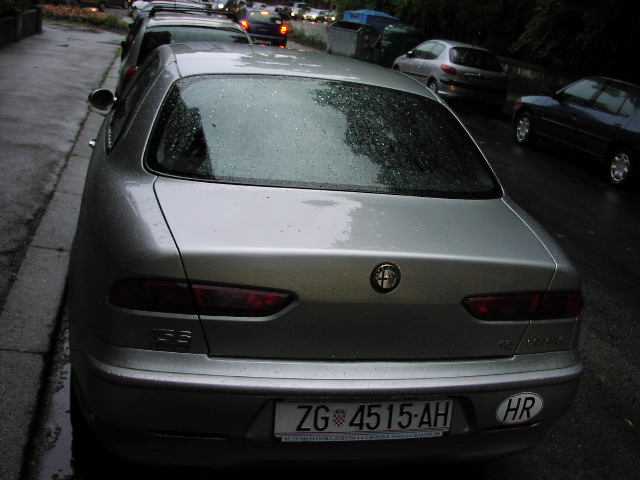

Orig


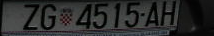

Characters = 10


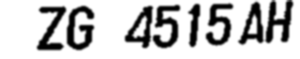

ZG4515AH


In [ ]:
car_name = 'ZG4515-AH.jpg'
orig_img = cv2.imread('drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/all/' + car_name)
cv2_imshow(orig_img)

for cnt in get_contours(orig_img, debug=False):
  x,y,w,h = cv2.boundingRect(cnt)

  if dirty_ratio_check(w, h, debug=False):
    plate = orig_img[y:y + int(h * 1.1), x:x + int(w * 1.1)]
    clean_plate, plate_shape = clean2_plate(orig_img.shape, plate, debug=False)

    if plate_shape is None:
      rot_plate = perspective_transformation(plate, cnt)
      clean_plate, plate_shape = clean2_plate(orig_img.shape, rot_plate, debug=False)
    
    plate_shape = get_plate_shape(clean_plate.shape)
    char_img, char_contour_list, char_text = get_characters(clean_plate, plate_shape, debug=False)
    if len(char_text) > 2:
      dbg(True, "Orig", plate)
      dbg(True, f"Characters = {len(char_contour_list)}", char_img)
      print(char_text)

# Debug all

## Bounding rectangle

In [ ]:
dir_path = 'drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/all/'

get_contours_t = 0
get_contours_count = 0
dirty_ratio_check_t = 0
dirty_ratio_check_count = 0
clean2_plate_t = 0
clean2_plate_count = 0
pers_transf_t = 0
pers_transf_count = 0
get_plt_shape_t = 0
get_plt_shape_count = 0
get_chars_t = 0
get_chars_count = 0
postprocess_t = 0
postprocess_count = 0
print_t = 0
print_count = 0

def do_stuff_timed(image_path):
  global get_contours_t, dirty_ratio_check_t, clean2_plate_t, pers_transf_t, get_plt_shape_t, get_chars_t, postprocess_t, print_t
  global get_contours_count, dirty_ratio_check_count, clean2_plate_count, pers_transf_count, get_plt_shape_count, get_chars_count, postprocess_count, print_count
  counter = 0

  orig_img = cv2.imread(image_path)

  cnt_time = time.time()
  contours = get_contours(orig_img)
  get_contours_count += 1
  get_contours_t += time.time() - cnt_time

  for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)

    drc_time = time.time()
    drc = dirty_ratio_check(orig_img.shape, w, h)
    dirty_ratio_check_count += 1
    dirty_ratio_check_t += time.time() - drc_time

    if drc:
      plate = orig_img[y:y + int(h * 1.1), x:x + int(w * 1.1)]

      cln_plt_time = time.time()
      clean_plate, passed_clean = clean2_plate(orig_img.shape, plate)
      clean2_plate_count += 1
      clean2_plate_t += time.time() - cln_plt_time

      if not passed_clean:
        prs_trf_time = time.time()
        rot_plate = perspective_transformation(clean_plate, cnt)
        pers_transf_count += 1
        pers_transf_t += time.time() - prs_trf_time

        cln_plt_time = time.time()
        clean_plate, _ = clean2_plate(orig_img.shape, rot_plate)
        clean2_plate_count += 1
        clean2_plate_t += time.time() - cln_plt_time

      get_plt_shape_time = time.time()
      plate_shape = get_plate_shape(clean_plate.shape)
      get_plt_shape_count += 1
      get_plt_shape_t += time.time() - get_plt_shape_time

      seg_time = time.time()
      char_img, char_cnt_list, char_text = get_characters(clean_plate, plate_shape)
      get_chars_count += 1
      get_chars_t += time.time() - seg_time

      if len(char_text) > 4 and is_text_valid(char_text):
        postprocess_time = time.time()
        char_text = postprocess_text(char_text)
        postprocess_count += 1
        postprocess_t += time.time() - postprocess_time

        print_time = time.time()
        print(image_path.replace(dir_path, ''), char_text)
        print_count += 1
        print_t += time.time() - print_time

        counter += 1

    if counter == 2:
      break

start_time = time.time()

for img_path in os.listdir(dir_path):
  do_stuff_timed(dir_path + img_path)

print("Time:", round(time.time() - start_time, 4))
print("get_contours", round(get_contours_t, 4), "#:", get_contours_count)
print("dirty_ratio_check", round(dirty_ratio_check_t, 4), "#:", dirty_ratio_check_count)
print("clean2_plate", round(clean2_plate_t, 4), "#:", clean2_plate_count)
print("perspective_transformation", round(pers_transf_t, 4), "#:", pers_transf_count)
print("get_plate_shape", round(get_plt_shape_t, 4), "#:", get_plt_shape_count)
print("get_character", round(get_chars_t, 4), "#:", get_chars_count)
print("postprocess_chars", round(postprocess_t, 4), "#:", postprocess_count)
print("print", round(print_t, 4), "#:", print_count)

# Time: 984.0129
# get_contours 8.9342 #: 499
# dirty_ratio_check 0.0486 #: 3992
# clean2_plate 14.3755 #: 3508
# perspective_transformation 0.5219 #: 673
# get_plate_shape 0.0244 #: 2835
# get_character 953.9316 #: 2835
# postprocess_chars 0.0069 #: 888
# print 0.329 #: 888

# Time: 578.6527
# get_contours 9.2545 #: 499
# dirty_ratio_check 0.0289 #: 2371
# clean2_plate 11.1097 #: 2119
# perspective_transformation 0.3332 #: 360
# get_plate_shape 0.0129 #: 1759
# get_character 551.4132 #: 1759
# postprocess_chars 0.0065 #: 834
# print 0.279 #: 834

ZG1455-AL.jpg ZG1455AL
ZG1455-AL.jpg ZG14554
ZG966-ZT.jpg ZG966ZT
ZG966-ZT.jpg ZG966ZT
BIRM160.jpg BLRM160
ZG4515-AH.jpg ZG4515AH
ZG3202-AM.jpg ZG3202AM
ZG3202-AM.jpg ZG3202AM
ZG0013-JP.jpg 4Z7G0013JP
ZG0013-JP.jpg BZG0013JP
ZG128-VJ.jpg ZG128VJ
ZG5572-AB.jpg ZG5572AB
ZG5572-AB.jpg ZG5572AB
ZG7640-AB.jpg ZG7640AB
ZG7640-AB.jpg ZG7640AB
0G501-0.jpg 0G5010
0G501-0.jpg OG5010
ZG6347-H.jpg ZG6347H
ZG6347-H.jpg ZG6347H
ZG2101-0.jpg ZG21010
ZG2101-0.jpg ZG21010
ZG759-RR.jpg ZG759RR
ZG759-RR.jpg BZ7G759RR
ZD601-J.jpg ZD601J
ZD601-J.jpg ZD601J
ZG192-0T.jpg ZG192OT
ZG192-0T.jpg ZG192OT
SGD3-164.jpg SGD3164
SGD3-164.jpg LSGD3164
ZG1628-AK.jpg ZG1628AK
ZG2563-AC.jpg HRZG563A
ZG2563-AC.jpg ZG2563AC
DU993-V.jpg UU33V
DU993-V.jpg DU993V
KI43GC.jpg K436C
KI43GC.jpg K436C
KC0010-KK.jpg KCOO10KK
KC0010-KK.jpg KCOO10KK
DU748-BH.jpg DU748BH
DU748-BH.jpg DU748BH
ZG668-IC.jpg Z668IC
ZG668-IC.jpg 6668C
ZG5114-E.jpg ZG5IIE
ZG5114-E.jpg ZG5SII4E
ZG1720-AJ.jpg ZG1720AJ
ZG1720-AJ.jpg ZG1720AJ
ZG474-DU.jpg ZG474

In [ ]:
dir_path = 'drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/all/'
start_time = time.time()

for i, line in tqdm(enumerate(os.listdir(dir_path))):
  counter = 0
  image_path = dir_path + line.strip()
  print("\n" + str(i), "File name:", line.strip())
  orig_img = cv2.imread(image_path)
# ------------------------------------------------------------------------------
  for cnt in get_contours(orig_img):
    if counter == 2:
      break
    x,y,w,h = cv2.boundingRect(cnt)
    # plate = cv2.UMat(orig_img[y:y + int(h * 1.1), x:x + int(w * 1.1)])
    # print("orig plate"); cv2_imshow(cv2.UMat.get(plate))
      
    if dirty_ratio_check(orig_img.shape, w, h):
      plate = orig_img[y:y + int(h * 1.1), x:x + int(w * 1.1)]
      clean_plate, clean_contour = clean2_plate(orig_img.shape, plate)

      if clean_contour is None:
        rot_plate = perspective_transformation(plate, cnt)
        clean_plate, clean_contour = clean2_plate(orig_img.shape, rot_plate)

      if clean_contour is not None:
        # chars = segment_chars(rot_plate)
        dbg(True, "Rotated plate", rot_plate)

        # if chars is not None and 3 < len(chars) < 12:
        #   dbg(True, "Rotated plate", rot_plate)
        #   concat_chars = hconcat_resize_min(chars)
        #   cv2_imshow(concat_chars)
        #   print(pytesseract_image_to_string(concat_chars))
        #   counter += 1
        

print("Time:", time.time() - start_time)

# Evaluation

Show all plates with handwritten coordinates.

In [ ]:
dir_path = 'drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/all/'
LP_coords = pd.read_csv(dir_path.replace("all/", "LP_coords.csv"))

for i, line in enumerate(os.listdir(dir_path)):
  print("\n" + str(i), "File name:", line)
  orig_img = cv2.imread(dir_path + line)
  coords = LP_coords[LP_coords.name == line.replace(".jpg", "")].iloc[0, 1:].values
  cv2_imshow(orig_img[coords[1]:coords[3], coords[0]:coords[2]])

Helper function

In [ ]:
def rectContains(contourRect: np.ndarray, csvRect: np.ndarray) -> bool:
  topLeftCorner = csvRect[0] >= contourRect[0] and csvRect[1] >= contourRect[1]
  bottomRightCorner = csvRect[2] <= contourRect[0] + contourRect[2] and csvRect[3] <= contourRect[1] + contourRect[3]
  return topLeftCorner and bottomRightCorner

In [ ]:
from difflib import SequenceMatcher

def similar(a, b):
  return SequenceMatcher(None, a, b).ratio()

In [ ]:
dir_path = 'drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/all/'
LP_coords = pd.read_csv('drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/LP_coords.csv')
passedCoords = list() #
passedOcr = dict() #
testPassed = False #
counter = 0

for i, line in enumerate(os.listdir(dir_path)):
  image_path = dir_path + line
  print("\n" + str(i), "File name:", line)
  orig_img = cv2.imread(image_path)

  for cnt in get_contours(orig_img):
    x,y,w,h = cv2.boundingRect(cnt)
      
    if dirty_ratio_check(orig_img.shape, w, h):
      if rectContains([x,y,w,h], LP_coords[LP_coords.name == line.replace(".jpg", "")].iloc[0, 1:].values): #
        testPassed = True #
        passedCoords.append(line) #

      plate = orig_img[y:y + int(h * 1.1), x:x + int(w * 1.1)]
      clean_plate, passed_clean = clean2_plate(orig_img.shape, plate)

      if not passed_clean:
        rot_plate = perspective_transformation(plate, cnt)
        clean_plate, _ = clean2_plate(orig_img.shape, rot_plate)

      plate_shape = get_plate_shape(clean_plate.shape)
      char_img, char_cnt_list, char_text = get_characters(clean_plate, plate_shape, debug=False)
      if len(char_text) > 4 and is_text_valid(char_text): #
        counter += 1
        char_text = postprocess_text(char_text)
        passedOcr[line] = [char_text, similar(line.replace('.jpg', '').replace('-', ''), char_text)] #

      if testPassed: #
        dbg(True, char_text, char_img)
        dbg(True, None, clean_plate) #
    testPassed = False #
    char_text = None #
    if counter == 2:
      counter = 0
      break

notPassedCoords = list()
for line in os.listdir(dir_path):
  if line in passedCoords:
    continue
  notPassedCoords.append(line)

notPassedOcr = list()
for line in os.listdir(dir_path):
  if line in passedOcr.keys():
    continue
  notPassedOcr.append(line)

In [ ]:
print(f"Unique passed: {len(np.unique(np.array(passedCoords)))}\t Passed: {len(passedCoords)}\t NotPassed: {len(notPassedCoords)}")
# Unique passed: 468	 Passed: 855	 NotPassed: 31
# Unique passed: 472	 Passed: 873	 NotPassed: 27
# Unique passed: 481	 Passed: 891	 NotPassed: 18
# Unique passed: 480	 Passed: 850	 NotPassed: 19 -> with char filter (alpha + num)

Unique passed: 480	 Passed: 850	 NotPassed: 19


In [ ]:
print(f"Passed: {len(passedOcr)}\t NotPassed: {len(notPassedOcr)}\t SumScore: {sum(map(float, np.array(list(passedOcr.values()))[:,1]))}\t MedianScore: {np.median(np.array(list(passedOcr.values()))[:,1].astype(float))}\t Mode: {stats.mode(np.array(list(passedOcr.values()))[:,1].astype(float))[0]}")
# RESIZE TIMES 2
# Passed: 447	 NotPassed: 52

# GAUSSIAN BLUR MASK
# Passed: 458	 NotPassed: 41

# RESIZE WIDTH = 350 FROM 300
# Passed: 454	 NotPassed: 45  SumScore: 355.0626130577371 MedianScore: 0.875

# RESIZE WIDTH = 320 FROM 350
# Passed: 454	 NotPassed: 45	 SumScore: 354.6799102857929	 MedianScore: 0.9230769230769231  Mode: [0.93333333]

# RESIZE WIDTH = 300
# Passed: 458	 NotPassed: 41	 SumScore: 348.8112260288734	 MedianScore: 0.875	 Mode: [0.93333333]

# pers transf
# Passed: 420	 NotPassed: 79	 SumScore: 315.33225971654826	 MedianScore: 0.875	 Mode: [0.93333333]

# REMOVE - and .jpeg from keys
# Passed: 458	 NotPassed: 41	 SumScore: 372.4375315860607	 MedianScore: 1.0	 Mode: [1.]

# POSTPROCESS replace 7 with Z in first two places
# Passed: 458	 NotPassed: 41	 SumScore: 374.6064876300167	 MedianScore: 1.0	 Mode: [1.]

# REMOVE black / white character cutouts in find_characters
# Passed: 456	 NotPassed: 43	 SumScore: 356.7554763863587	 MedianScore: 0.8571428571428571	 Mode: [1.]

# ADD mask bitwise_not in find_characters
# Passed: 471	 NotPassed: 28	 SumScore: 385.2666397328158	 MedianScore: 0.9333333333333333	 Mode: [1.] <-------------------------------------------------

# MINIMUM CHARACTERS = 5
# Passed: 463	 NotPassed: 36	 SumScore: 406.4105957767718	 MedianScore: 1.0	 Mode: [1.]

# counter == 2: break
# Passed: 463	 NotPassed: 36	 SumScore: 409.0649149869734	 MedianScore: 1.0	 Mode: [1.]

# with char filter (alph + num) - WITHOUT OTSU
# Passed: 446	 NotPassed: 53	 SumScore: 409.3119227178048	 MedianScore: 1.0	 Mode: [1.]

Passed: 446	 NotPassed: 53	 SumScore: 409.3119227178048	 MedianScore: 1.0	 Mode: [1.]


In [ ]:
passedOcr

In [ ]:
notPassedOcr

In [ ]:
# "ZG7178-I", "ZG443-TP", "ZG311-MR", "DU166-BF", "ZG1382-AB",
# "G88LFB", "ZG8901-Z", "BA056GD", "ZG806-KF", "VZ876-CI",
# "ZG312-VZ", "ZG9952-P", "ZG9461-N", "ZG408-00",
# "ZG511-SF", "HDL-798", "ZG2462-AE",
notPassedButDetected = ["VU279-AE", "ZG6304-H", "BMA19-31"]

In [ ]:
# 'G22SKD.jpg', 'ZG3632-L.jpg', 'ST937-IS.jpg', 'SK195-BK.jpg',
notPassedStaples = ['ZG668-IC.jpg', 'ZG9074-F.jpg', 'ZG885-PK.jpg',
                    'ZG163-DB.jpg', 'NA552-C.jpg', 'ZG7523-AF.jpg', 'ZG1041-P.jpg',
                    '530-C-001.jpg', 'ZG8894-AB.jpg', 'ZG484-LD.jpg',
                    'ZG4208-I.jpg', 'ZG9005-L.jpg', 'NBJ30-16.jpg', 'LL-KK50.jpg',
                    'ZG660-UU.jpg', 
                    'ZG4100-AC.jpg', 'ZG461-DJ.jpg', 'ZG667-BU.jpg', 'RI681-GN.jpg',
                    'ZG637-LV.jpg', 'NJA14-73.jpg', 'ZG4215-AC.jpg', 'ZG2661-AJ.jpg',
                    'VU133-C.jpg', 'AHV90-02.jpg', '066-A-007.jpg', '018A050.jpg']
notPassedCoords

In [ ]:
ofInterest = ["ZG1455-AL", "ZG9023-AI", "PU781-D", "ST364-FI", "ZG385-SZ",
              "ZG311-MR", "ZG969-LN", "KA570-CD", "ZG2751-B", "ZG3083-J",
              "ZG959-JJ", "ZG1532-AB", "IM660-P", "BRJ193", "GS592-AC",
              "SP495AP", "ZG312-VZ", "ZG927-UZ", "513-J-636", "BA434DD",
              "ZG895-TJ", "DJ944-AE", "ZG483-ZM", "ZG4256-AI", "ZG8135-N",
              "489-E-754", "ZG9807-E", "HGAS1802", "HHR850", "ZG1375-C",
              "BV593KX", "HB698AI"]

In [ ]:
dir_path = 'drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/all/'
LP_coords = pd.read_csv('drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/LP_coords.csv')

# for line in os.listdir(dir_path):
for i, line in enumerate(notPassedOcr):
  if line in notPassedCoords:
    continue
  # testPassed = False
  image_path = dir_path + line.strip()
  print("\n" + str(i), "File name:", line.strip())
  orig_img = cv2.imread(image_path)

  for cnt in get_contours(orig_img):
    x,y,w,h = cv2.boundingRect(cnt)
      
    if dirty_ratio_check(orig_img.shape, w, h):
      plate = orig_img[y:y + int(h * 1.1), x:x + int(w * 1.1)]
      if rectContains([x,y,w,h], LP_coords[LP_coords.name == line.strip().replace(".jpg", "")].iloc[0, 1:].values):
        testPassed = True
        # dbg(True, 'contour', plate)
      clean_plate, passed_clean = clean2_plate(orig_img.shape, plate)
      # dbg(True, "clean", clean_plate)

      if not passed_clean:
        rot_plate = perspective_transformation(clean_plate, cnt)
        # dbg(True, "rotated", rot_plate)
        clean_plate, _ = clean2_plate(orig_img.shape, rot_plate)
        # dbg(True, "clean after rotate", clean_plate)

      if testPassed:
        plate_shape = get_plate_shape(clean_plate.shape)
        char_img, char_cnt_list, char_text = get_characters(clean_plate, plate_shape, debug=False)
        if len(char_text) > 2:
          dbg(True, "Orig", plate)
          dbg(True, f"Characters = {len(char_cnt_list)}", char_img)
          print(char_text)
    # testPassed = False

# Time & Eval

In [ ]:
dir_path = 'drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/all/'
LP_coords = pd.read_csv('drive/MyDrive/DP/Datasets/LicensePlateRecognition/500RearViewImages/LP_coords.csv')

get_contours_t = get_contours_count = 0
dirty_ratio_check_t = dirty_ratio_check_count = 0
clean2_plate_t = clean2_plate_count = 0
pers_transf_t = pers_transf_count = 0
get_plt_shape_t = get_plt_shape_count = 0
get_chars_t = get_chars_count = 0
postprocess_t = postprocess_count = 0
print_t = print_count = 0

resize_gray_thresh_t, find_characters_t, handle_square_plate_t, pytess_t = 0, 0, 0, 0

passedCoords = list() #
passedOcr = dict() #

def do_stuff_timed_evaluated(image_path):
  global get_contours_t, dirty_ratio_check_t, clean2_plate_t, pers_transf_t, get_plt_shape_t, get_chars_t, postprocess_t, print_t
  global get_contours_count, dirty_ratio_check_count, clean2_plate_count, pers_transf_count, get_plt_shape_count, get_chars_count, postprocess_count, print_count
  global passedCoords, passedOcr
  
  img_name = image_path.replace(dir_path, '').replace('.jpg', '') #
  counter = 0

  orig_img = cv2.imread(image_path)

  cnt_time = time.time()
  contours = get_contours(orig_img)
  get_contours_count += 1
  get_contours_t += time.time() - cnt_time

  for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)

    drc_time = time.time()
    drc = dirty_ratio_check(w, h)
    dirty_ratio_check_count += 1
    dirty_ratio_check_t += time.time() - drc_time

    if drc:
      if rectContains([x,y,w,h], LP_coords[LP_coords.name == img_name].iloc[0, 1:].values): #
        passedCoords.append(img_name) #

      plate = orig_img[y:y + int(h * 1.1), x:x + int(w * 1.1)]

      cln_plt_time = time.time()
      clean_plate, passed_clean = clean2_plate(orig_img.shape, plate)
      clean2_plate_count += 1
      clean2_plate_t += time.time() - cln_plt_time

      if not passed_clean:
        prs_trf_time = time.time()
        rot_plate = perspective_transformation(clean_plate, cnt)
        pers_transf_count += 1
        pers_transf_t += time.time() - prs_trf_time

        cln_plt_time = time.time()
        clean_plate, _ = clean2_plate(orig_img.shape, rot_plate)
        clean2_plate_count += 1
        clean2_plate_t += time.time() - cln_plt_time

      get_plt_shape_time = time.time()
      plate_shape = get_plate_shape(clean_plate.shape)
      get_plt_shape_count += 1
      get_plt_shape_t += time.time() - get_plt_shape_time

      seg_time = time.time()
      char_img, char_cnt_list, char_text = get_characters(clean_plate, plate_shape)
      get_chars_count += 1
      get_chars_t += time.time() - seg_time

      if len(char_text) > 4 and is_text_valid(char_text):
        postprocess_time = time.time()
        char_text = postprocess_text(char_text)
        postprocess_count += 1
        postprocess_t += time.time() - postprocess_time

        passedOcr[img_name] = [char_text, similar(img_name.replace('-', ''), char_text)] #

        print_time = time.time()
        print(img_name, char_text)
        print_count += 1
        print_t += time.time() - print_time

        counter += 1

    char_text = None #
    if counter == 2:
      break

start_time = time.time()

for img_path in os.listdir(dir_path):
  do_stuff_timed_evaluated(dir_path + img_path)

print("\nTime:", round(time.time() - start_time, 4))
print("get_contours", round(get_contours_t, 4), "#:", get_contours_count)
print("dirty_ratio_check", round(dirty_ratio_check_t, 4), "#:", dirty_ratio_check_count)
print("clean2_plate", round(clean2_plate_t, 4), "#:", clean2_plate_count)
print("perspective_transformation", round(pers_transf_t, 4), "#:", pers_transf_count)
print("get_plate_shape", round(get_plt_shape_t, 4), "#:", get_plt_shape_count)
print("get_character", round(get_chars_t, 4), "#:", get_chars_count)
print("postprocess_chars", round(postprocess_t, 4), "#:", postprocess_count)
print("print", round(print_t, 4), "#:", print_count)

print("resize_gray_thresh", round(resize_gray_thresh_t, 4))
print("find_characters", round(find_characters_t, 4))
print("handle_square_plate", round(handle_square_plate_t, 4))
print("pytess", round(pytess_t, 4))

notPassedCoords = list()
for line in os.listdir(dir_path):
  line = line.replace(dir_path, '').replace('.jpg', '')
  if line in passedCoords:
    continue
  notPassedCoords.append(line)

notPassedOcr = list()
for line in os.listdir(dir_path):
  line = line.replace(dir_path, '').replace('.jpg', '')
  if line in passedOcr.keys():
    continue
  notPassedOcr.append(line)

print(f"\nUnique passed LP: {len(np.unique(np.array(passedCoords)))}\t Passed LP: {len(passedCoords)}\t NotPassed LP: {len(notPassedCoords)}")
print(f"Passed OCR: {len(passedOcr)}\t NotPassed OCR: {len(notPassedOcr)}\t SumScore: {sum(map(float, np.array(list(passedOcr.values()))[:,1]))}\t MedianScore: {np.median(np.array(list(passedOcr.values()))[:,1].astype(float))}\t Mode: {stats.mode(np.array(list(passedOcr.values()))[:,1].astype(float))[0]}")

ZG1455-AL ZG1455
ZG966-ZT ZG966ZT
ZG3202-AM ZG3202AM
ZG0013-JP BZG0013JP
ZG128-VJ ZG128VJ
ZG5572-AB ZG5572AB
ZG7640-AB ZG7640AB
0G501-0 0G5010
ZG6347-H ZG6347H
ZG2101-0 ZG21010
ZG759-RR ZG759RR
ZD601-J ZD601J
ZG192-0T ZG1920T
SGD3-164 SGD3164
ZG1628-AK ZG1628AK
ZG2563-AC ZG2563AC
KI43GC K436C
KC0010-KK KCOO10KK
DU748-BH DU748BH
ZG1720-AJ ZG1720AJ
ZG474-DU ZG474DU
ZG505-CE ZG505CE
KK23-13L KK2318L
ZG120-EL ZG120EL
SI160-BB GS160BB
ZG375-UJ ZG375UJ
ZG401-CC ZG401CC
ZG394-JU ZG3984JU
RI393-BD R393BD
KKH5-122 KKH5122
ZG568-TM ZG568TM
ZG521-II ZG52111
ST317-KJ ST317KJ
VU306-J VU306J
ZG5942-G ZG59842G
ZG293-P ZG293P
VU3003-VU VU3003VU
ZG120-JL ZG120JL
PU658-EI PU6581
ZG9074-F T43854
ZG912-CK ZG12CK
BJ765-BM BJ76BM
ZG848-IK WGB48K
RI949-GE R949GE
ZG5687-AR ZG5687AR
0S001-GS OS001GS
ZG160-DU ZG160DU
ZG248-EB ZG248EB
ZG2745-AM ZG27454M
ZG636-RG 26636RG
ZG627-EK ZG627EK
VZ785-ER VZ785ER
0G788-P 0G788P
ZG885-PK ZG885PK
ZG4940-L ZGA940L
LN608AC LN608AC
SI124-BP S124BP
ZG5800-K ZG5800K
ZG495-ZR ZG4

In [ ]:
#-----------------------------------combined------------------------------------
# Time: 211.9251
# get_contours 8.5305 #: 499
# dirty_ratio_check 0.016 #: 2440
# clean2_plate 11.0997 #: 2180
# perspective_transformation 0.3074 #: 370
# get_plate_shape 0.01 #: 1810
# get_character 182.4481 #: 1810
# postprocess_chars 0.0053 #: 819
# print 0.2975 #: 819
# resize_gray_thresh 1.3133
# find_characters 3.4988
# handle_square_plate 23.8841
# pytess 153.6891

# Unique passed LP: 481	 Passed LP: 891	 NotPassed LP: 18
# Passed OCR: 450	 NotPassed OCR: 49	 SumScore: 418.57808351778925	 MedianScore: 1.0	 Mode: [1.]

#---------------------------------edge focused----------------------------------
# Time: 160.5183
# get_contours 6.7027 #: 499
# dirty_ratio_check 0.019 #: 3459
# clean2_plate 10.0996 #: 3202
# perspective_transformation 0.3603 #: 678
# get_plate_shape 0.0125 #: 2524
# get_character 134.1861 #: 2524
# postprocess_chars 0.0029 #: 424
# print 0.143 #: 424
# resize_gray_thresh 1.7048
# find_characters 4.5738
# handle_square_plate 32.4149
# pytess 95.4419

# Unique passed LP: 468	 Passed LP: 470	 NotPassed LP: 31
# Passed OCR: 422	 NotPassed OCR: 77	 SumScore: 390.7942358295297	 MedianScore: 1.0	 Mode: [1.]

#----------------------------------light mask-----------------------------------
# Time: 165.0975
# get_contours 7.5744 #: 499
# dirty_ratio_check 0.0191 #: 3479
# clean2_plate 8.3828 #: 3295
# perspective_transformation 0.3199 #: 653
# get_plate_shape 0.0134 #: 2642
# get_character 139.5115 #: 2642
# postprocess_chars 0.0029 #: 409
# print 0.162 #: 409
# resize_gray_thresh 1.5876
# find_characters 4.6833
# handle_square_plate 40.2828
# pytess 92.9079

# Unique passed LP: 433	 Passed LP: 433	 NotPassed LP: 66
# Passed OCR: 405	 NotPassed OCR: 94	 SumScore: 378.14877752965987	 MedianScore: 1.0	 Mode: [1.]